<a href="https://colab.research.google.com/github/fezilemahlangu/Natural-Language-Processing-Project/blob/main/NLP_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Fezile Mahlangu 

#2089676

#NLP Project 


---

Project: Spam Classification Using Naive Bayes

Aim: Train and optimize a spam classifier using Naive Bayes classification model

Tasks:
- [ ] Implement a Naive Bayes Model
- [ ] Investigate the effect of using different features 
- [ ] Evaluate the performance of different models
- [ ] Optimize the model for better performance






---



# Imports

In [36]:
import numpy as np
import pandas as pd
import nltk
nltk.download('stopwords')
from nltk.tokenize import word_tokenize, wordpunct_tokenize
nltk.download("wordnet")
from nltk.stem.wordnet import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer
nltk.download('omw-1.4')

from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix,f1_score
from sklearn.metrics import ConfusionMatrixDisplay

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


# Loading data

In [3]:
#loading data -> Remember to remove drive path and use normal path

train_df = pd.read_csv("/content/drive/MyDrive/NLP/train.csv")
val_df = pd.read_csv("/content/drive/MyDrive/NLP/val.csv")
test_df = pd.read_csv("/content/drive/MyDrive/NLP/test.csv")
display(train_df)

,text,label
0,"Subject: thank you\r\nami and daren , , , ,\r\...",0
1,"Subject: spot or firm tickets\r\nvance ,\r\nth...",0
2,Subject: software\r\nmicrosoft windows xp prof...,1
3,Subject: noms / actual flow for 2 / 27\r\nwe a...,0
4,Subject: superb so . ftware\r\nyoull discover ...,1
...,...,...
3097,Subject: \r\n( envelope - from 20040929124340 ...,1
3098,Subject: re : intraday eastrans nomination cha...,0
3099,Subject: meter 1601\r\ndaren - meter 1601 has ...,0
3100,Subject: need legal help ?\r\nto unsubscribe f...,1


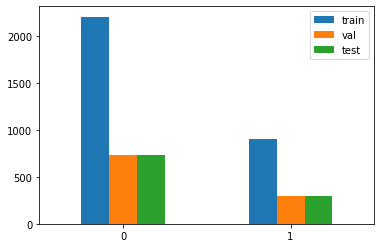

In [4]:

train = [train_df[train_df.label==0].count()[0],train_df[train_df.label==1].count()[0]]
test = [test_df[test_df.label==0].count()[0],test_df[test_df.label==1].count()[0]]
val = [val_df[val_df.label==0].count()[0],val_df[val_df.label==1].count()[0]]

index = ['0', '1']
df = pd.DataFrame({'train': train,
                   'val': val, 'test':test}, index=index)
ax = df.plot.bar(rot=0)



# Preprocessing of data

The text will be tokenized and there will be a list of words for each sentence 

In [5]:
train_df.head()

,text,label
0,"Subject: thank you\r\nami and daren , , , ,\r\...",0
1,"Subject: spot or firm tickets\r\nvance ,\r\nth...",0
2,Subject: software\r\nmicrosoft windows xp prof...,1
3,Subject: noms / actual flow for 2 / 27\r\nwe a...,0
4,Subject: superb so . ftware\r\nyoull discover ...,1


In [15]:
#creating x and y from dataframes 
train_x = train_df.text
train_y = train_df.label

test_x = test_df.text
test_y = test_df.label

val_x = val_df.text
val_y = val_df.label

len(train_x)

# https://www.kaggle.com/code/conniedeng/nlp-eron-dataset


3102

In [6]:
def split_row(row):
  #splits row by "\n"
  return row.split("\n")

In [7]:
def tokenize(row):
  #splits by white space and punct 
  return wordpunct_tokenize(row)

In [8]:
def handle_money(row):
  #puts $5.99 back from ["$","5",".","99"]
  leng = len(row)
  i = 0
  while leng != 0 :
    if row[i]=='$' and row[i+2].isnumeric():
      row = row[:i+1] + row[(i+2):]
      leng-=1

    elif (row[i] == '.' and row[i+2].isnumeric() and row[i-2].isnumeric()):
      row = row[0:i-1] + row[i:i+1] + row[i+2:]
      leng-=2
    i+=1
    leng-=1

  return row
  

In [19]:
def remove_punct(row):
  #romoves punctuation marks 
  # [word for word in row if word.isalpha() or word[0] == "$" or word=="!"] 

  return [word for word in row if word.isalpha()] #check this thos 


In [10]:
stemmer = nltk.stem.porter.PorterStemmer()
def stem_words(row):
  #function that performs stemming 
  # removes word ending crudely -ing 
  return [stemmer.stem(i) for i in row]


In [12]:
lemmatizer = nltk.stem.wordnet.WordNetLemmatizer()
def lemmatize(row):
  #performs lemmatization 
  # make a word a root 
  return [lemmatizer.lemmatize(i) for i in row]

In [27]:
a = ["getting", "google", "meeting","rocks"]

lemmatize(a)

# stem_words(a)

['getting', 'google', 'meeting', 'rock']

In [13]:
tokenizer = RegexpTokenizer('\w+|\$[\d\.]+|\S+')

def tokenize_with_money(row):
  #dont split if theres money 
  return tokenizer.tokenize(row)


In [14]:
stop_words = nltk.corpus.stopwords.words('english')

def remove_stop_words(row):
  #removes stop words -> really frequent words  
  return [i for i in row if i not in stop_words]

In [267]:
print(train_x[2])
# a = split_row(train_x[0])
# print(a)
# 
a = handle_money(train_x[2])

print(a)
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")

a = tokenize_with_money(a)
print(a)
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")

a = remove_punct(a)
print(a)
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")

a = remove_stop_words(a)
print(a)
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")


a = stem_words(a)
print(a)
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")


a = lemmatize(a)
print(a)
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")


Subject: software
microsoft windows xp professioznal 2002
retail price : $ 270 . 99 our low pricie : $ 50 . 00 you save : $ 220 . 00
adobe photoshkop 7 . 0
retail price : $ 609 . 99 our low price : $ 60 . 00 you savue : $ 550 . 00
microsoft office xp professional 2002
retail price : $ 579 . 99 our low price : $ 60 . 00 you savxe : $ 510 . 00
adobe illustrator 10 retaitl price : $ 270 . 99 our low price : $ 60 . 00 you savxe : $ 210 . 00
corel draw graphics suite 11 rehtail price : $ 270 . 99 our low pricje : $ 60 . 00 you save : $ 210 . 00
delphi 7
retaifl price : $ 404 . 99 our low price : $ 60 . 00 you save : $ 335 . 00
and more ! ! !
why so cheap ?
all the software is oem - meaninag that you don ' t get the box and the manual with your software . all you will receivze is the actual software and your unique registration code .
all the softwarue is in the english language for pc . our offers are unbeatablke and we always update our prices to make sure we provide you with the besft pos

In [48]:
clean_train_x = []
for i in train_x:

  text = tokenize_with_money(i)

  text = remove_punct(text)

  text = remove_stop_words(text)

  text = stem_words(text)

  text = lemmatize(text)

  clean_train_x.append(text)


In [33]:
print("Text before preprocessing: \n")
print(train_x[0])
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")
print("Text after preprocessing: \n")
print(clean_train_x[0])
print("----------------------------------------------------------------------------------------------------------------------------------------------------------------------")

Text before preprocessing: 

Subject: thank you
ami and daren , , , ,
just wanted again to say thanks ! ! ! , for the great time at st . pete ' s beach ,
fla .
the company , food , fishing and yes , of coarse
the drink or many drinks were great ! ! ! daren , can relate to the drinks .
i enjoyed meeting everyone there .
we appreciate your business and look forward to continue our business relation
with enron in the future .
sincerely ,
tim
----------------------------------------------------------------------------------------------------------------------------------------------------------------------
Text after preprocessing: 

['subject', 'thank', 'ami', 'daren', 'want', 'say', 'thank', 'great', 'time', 'st', 'pete', 'beach', 'fla', 'compani', 'food', 'fish', 'ye', 'coars', 'drink', 'mani', 'drink', 'great', 'daren', 'relat', 'drink', 'enjoy', 'meet', 'everyon', 'appreci', 'busi', 'look', 'forward', 'continu', 'busi', 'relat', 'enron', 'futur', 'sincer', 'tim']
---------------------

# Training a standard Naive Bayes model 

In [49]:
#transforming to numeric form for MultinomialNB

count_vector = CountVectorizer()

clean_train_x = [" ".join(i) for i in clean_train_x ] #turn to string for count_vector 


trans_x = count_vector.fit_transform(clean_train_x)

trans_x_dense = np.array(trans_x.todense())

Model1 = MultinomialNB().fit(trans_x_dense,train_y)

In [44]:
trans_x[0][0]

<1x28388 sparse matrix of type '<class 'numpy.int64'>'
	with 32 stored elements in Compressed Sparse Row format>

## Naive Bayes model using 10 most frequent words as features 

## Naive Bayes model using 100 most frequent words as features 

## Naive Bayes model removing 100 most frequent words from features 

## Naive Bayes model using subject line as the feature set

# Evaluation using validation set

## Calculating the evaluation metrics

## Comparing all 5 models 

## Recommended model and reasons

# Evaluation using test set

## Is recommendation still valid?

# Implementation of 1 more variation to improve performance 

## Evaluation of improved model